In [48]:
B = 80
L = 30
D = 4.4 

import gmsh 
from CompositeSandwich.box_labeling import box_labeling
# create a box with Lx = L , Ly = B, Lz = D
gmsh.initialize()

gmsh.model.add("box")

box = gmsh.model.occ.addBox(0, 0, 0, L, B, D)
# add box physical group
gmsh.model.occ.synchronize()
ph = gmsh.model.addPhysicalGroup(3, [box], -1)
gmsh.model.setPhysicalName(3, ph, "BOX")

# synco 
gmsh.model.occ.synchronize()

# label the box
box_labeling(box,"BOX")
gmsh.model.occ.synchronize()

# set mesh size
ms = 1
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), ms)
# mesh 
gmsh.model.mesh.generate(3)
# quadratic elements
gmsh.model.mesh.setOrder(2)
# save in inp format
gmsh.write("box.inp")

In [49]:
from djccx.inp.inp import inp

inp_f = inp("box.inp")
# select points that satisfy the condition x = 0 and z = 0


In [50]:
inp_f.cards

array([Card (None) :*HEADING, Card (*NODE) :*NODE,
       Card (*ELEMENT) :SURFACE1, Card (*ELEMENT) :SURFACE2,
       Card (*ELEMENT) :SURFACE3, Card (*ELEMENT) :SURFACE4,
       Card (*ELEMENT) :SURFACE5, Card (*ELEMENT) :SURFACE6,
       Card (*ELEMENT) :VOLUME1, Card (*ELSET) :BOX_X0,
       Card (*ELSET) :BOX_XL, Card (*ELSET) :BOX_Y0,
       Card (*ELSET) :BOX_YL, Card (*ELSET) :BOX_Z0,
       Card (*ELSET) :BOX_ZL, Card (*ELSET) :BOX], dtype=object)

In [51]:

nodes = inp_f.nodes.df
nodes = nodes[(nodes["x"] == L) & (nodes["z"] == 0)]
SUPPORT = inp_f.CreateNsetFromIds(nodes.index,"SUPPORT")

nodes = inp_f.nodes.df
nodes = nodes[(nodes["x"] == 0) & (nodes["z"] == D)]
LOAD = inp_f.CreateNsetFromIds(nodes.index,"LOAD")

xplane = inp_f.select("BOX_X0","elset")
SYMMETRY  = inp_f.CreateNsetFromElset(xplane,"SYMMETRY")
# remove 1 and 2 
inp_f.remove_by_type(1)
inp_f.remove_by_type(2)

#
E = 1e6
nu = 0.3
name = "Elastic"
mat = inp_f.CreateElasticMaterial(name,E,nu)
all = inp_f.CreateElsetAll()
sec = inp_f.CreateSolidSection(all,mat)

# 
istep = inp_f.CreateStaticStep()
istep.CreateBoundary(LOAD,3,displ=-3)
istep.CreateBoundary(SUPPORT,3,displ=0)
istep.CreateBoundary(SYMMETRY,1,displ=0)

ifrd = inp_f.run("output")


Running Calculix at:  output
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_BendingTest\NumericalBasicRotura\output\out.txt
Command:
 C:\Program Files\Microsoft MPI\Bin\mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  15392 

Calculix finished



In [52]:
nodes = inp_f.nodes.df

nodes = nodes[(nodes["x"]  == 0) & (nodes["z"] ==  D)]
nodes = nodes.copy()

nodes["F3"] = ifrd["data"]["F3"][nodes.index]
F = - nodes["F3"].sum()

In [53]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'F3')

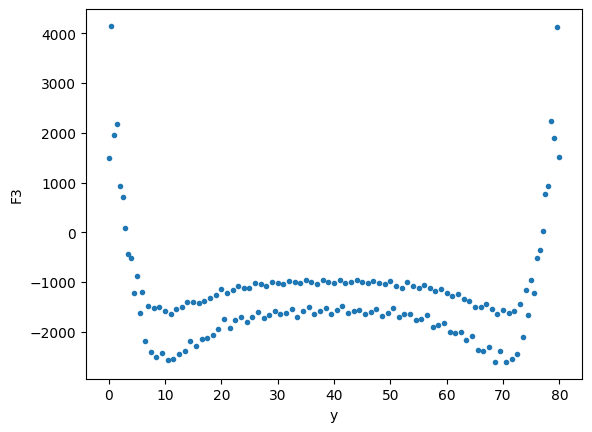

In [54]:
plt.plot(nodes["y"],nodes["F3"],".")
plt.xlabel("y")
plt.ylabel("F3")

In [55]:
nodes = inp_f.nodes.df
nodes = nodes[(nodes["x"] == 0) & (nodes["z"] ==  0)]

nodes = nodes.copy()

nodes["P1"] = ifrd["data"]["P1"][nodes.index]

Text(0, 0.5, 'P1')

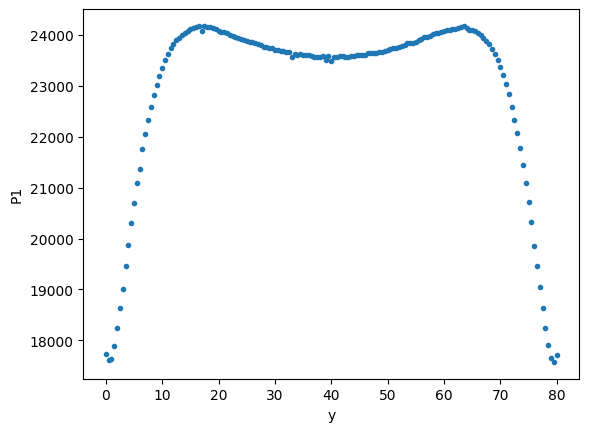

In [56]:
plt.plot(nodes["y"],nodes["P1"],".")
Pmax = nodes["P1"].max()
plt.xlabel("y")
plt.ylabel("P1")

In [57]:
Pmax_teorico = (3/2) * ((2*F)*(2*L)) / (B*D**2)

In [58]:
print(f"Pmax = {Pmax}")
print(f"Pmax_teorico = {Pmax_teorico}")
print(f"Error = {100*abs(Pmax - Pmax_teorico)/Pmax_teorico} %")

Pmax = 24177.00366791482
Pmax_teorico = 23291.419358212803
Error = 3.802191253706281 %
